<a href="https://colab.research.google.com/github/theinem/Deteccion_ori_y_dnaABox_Ecoli/blob/master/Detecci%C3%B3n_ori_y_dnaABox_Ecoli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Detección de ori y dnaA box para la bacteria Escherichia Coli***
Este notebook contiene los pasos para emplear Google Colab para el análisis del genoma de la baceteria E. Coli. Está un paso a paso y una explicación final de las aplicaciones y limitaciones del algoritmo.

### Montar el disco virtual

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Librerías

In [0]:
import matplotlib.pyplot as plt

### Lectura del archivo

In [0]:
f = open('/content/drive/My Drive/Colab Notebooks/Bioinformatics/E_coli.txt', 'r')
genome = f.read()

### Frecuencia de Citosinas en una longitud igual a la mitad de la secuencia

In [0]:
# Input:  genoma y símbolo
# Output: FasterSymbolArray(Genome, symbol)
def FasterSymbolArray(Genome, symbol):
    array = {}
    n = len(Genome)
    ExtendedGenome = Genome + Genome[0:n//2]

    # look at the first half of Genome to compute first array value
    array[0] = PatternCount(symbol, Genome[0:n//2])

    for i in range(1, n):
        # start by setting the current array value equal to the previous array value
        array[i] = array[i-1]

        # the current array value can differ from the previous array value by at most 1
        if ExtendedGenome[i-1] == symbol:
            array[i] = array[i]-1
        if ExtendedGenome[i+(n//2)-1] == symbol:
            array[i] = array[i]+1
    return array

def Reverse(Pattern):
    return Pattern[::-1]

def Complement(Pattern):
    complement = ''
    for char in Pattern:
        if char=='A':  complement += 'T'
        if char=="T":  complement += 'A'
        if char=="G":  complement += 'C'
        if char=="C":  complement += 'G'
    return complement

def ReverseComplement(Pattern):
    Pattern = Reverse(Pattern) # realiza el inverso de una cadena de caracteres
    Pattern = Complement(Pattern) # realiza el complemento de cada nucleótido
    return Pattern

# Input:  genoma y patrón
# Output: cantidad de veces que el patrón está en el genoma
#Esta función cuenta tanto la presencia del patrón como su reverso complementario
def PatternCount(Pattern, Text):
    count = 0
    for i in range(len(Text)-len(Pattern)+1):
        if Text[i:i+len(Pattern)] == Pattern or Text[i:i+len(Pattern)] == ReverseComplement(Pattern):
            count = count+1
    return count 

def FrequencyMap(Text, k):
    freq = {}
    n = len(Text)
    for i in range(n-k+1):
        Pattern = Text[i:i+k]
        freq[Pattern] = PatternCount(Pattern, Text)
    return freq

def FrequentWords(Text, k):
    words = []
    freq = FrequencyMap(Text, k)
    m = max(freq.values())
    for key in freq:
        if freq[key] == m:
            words.append(key)
    return words, freq

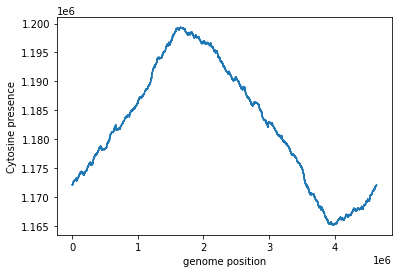

In [5]:
array = FasterSymbolArray(genome, 'C')
plt.plot(*zip(*sorted(array.items())))
plt.xlabel('genome position')
plt.ylabel('Cytosine presence')
plt.show()

### Sesgo de Guanina y Citosina

In [0]:
# Input:  genoma
# Output: lista del sesgo acumulado
def SkewArray(Genome):
    skew = [0]
    score = {"A":0, "T":0, "C":-1, "G":1}
    for i in range(1,len(Genome)+1):
            skew.append(score[Genome[i-1]] + skew[i-1])
    return skew
    
# Input:  genoma
# Output: lista de posiciones donde se encuentra el mínimo del sesgo
def MinimumSkew(Genome):
    skew = SkewArray(Genome)
    minimum = min(skew)
    positions = [index for index, element in enumerate(skew) if element == minimum]
    return positions

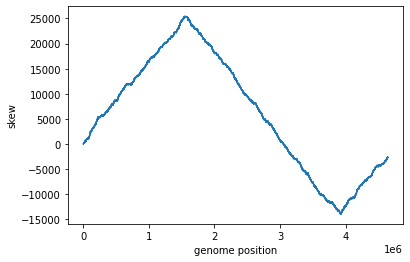

In [7]:
skew = SkewArray(genome)
plt.plot(skew)
plt.xlabel('genome position')
plt.ylabel('skew')
plt.show()

### Candidatos para ***ori***
En esta etapa se generan los candidatos a ori (ori_candidates)

In [8]:
print('Maximum skew is in position:', skew.index(max(skew)))
print('Minimum skew is in position:', skew.index(min(skew)), 'AND is an ori candidate')

Maximum skew is in position: 1550413
Minimum skew is in position: 3923620 AND is an ori candidate


In [9]:
ori_candidates = MinimumSkew(genome)
ori_candidates

[3923620, 3923621, 3923622, 3923623]

### Distancia de Hamming para caracteres

In [0]:
def HammingDistance(p, q):
    if len(p) == len(q):
        distance = 0
        for i in range(len(p)):
            if p[i] != q[i]:
                distance += 1
        return distance
    else:
        print('character length are not equal!')

def ApproximatePatternMatching(Text, Pattern, d):
    positions = [] # inicialización de lista de posiciones
    for i in range(len(Text)-len(Pattern)+1):
        q = Text[i:i+len(Pattern)]
        if HammingDistance(Pattern, q) <= d:
            positions.append(i)
    return positions

# Input:  patrón, texto (genoma) y d(distancia de hamming mínima)
# Output: frecuencia de patrones
def ApproximatePatternCount(Pattern, Text, d):
    count = 0 # inicializar contador
    for i in range(len(Text)-len(Pattern)+1):
        q = Text[i:i+len(Pattern)]
        if HammingDistance(Pattern, q) <= d:
            count += 1
        if HammingDistance(ReverseComplement(Pattern), q) <= d:
            count += 1
    return count

In [11]:
p = 'GGGCCCTTT'
q = 'GGACCCTGG'
HammingDistance(p, q) #valor esperado = 3

3

### Conteo de k-mers dentro de la ventana candidata para ori
Se emplea una ventana de 500 y se busca un 9-mer. La lista **words** contendrá todas las cadenas posibles.

In [12]:
k = 9
window_size = 500
Text = genome[ori_candidates[0] : ori_candidates[0] + window_size]
words, freq = FrequentWords(Text, k)
print(words)

['AAGGATCCG', 'AGGATCCGG', 'CTGTGGATA', 'TGTGGATAA', 'GTGGATAAC', 'AAGATCAAC', 'AGATCAACA', 'GCTGGGATC', 'TGGATAACT', 'AGTTATCCA', 'GTTATCCAC', 'TTATCCACA', 'TATCCACAG', 'GATCCCAGC', 'TGTTGATCT', 'GTTGATCTT']


### Filtrado de 9-mers y postulación de posibles dnaA boxes
Ahora se seguirá un proceso de análisis para filtrar los 9-mers más frecuentes (si se encuentra un inverso complementario, se sumará tanto al inverso como al original, esto duplicará los contadores, pero simplifica la lógica del código).

In [13]:
mismatch = 1
dnaA_candidates = {}
for word in words:
  dnaA_candidates[word] = ApproximatePatternCount(word, Text, mismatch)
print('Frecuencia de cadenas de longitud 9:', dnaA_candidates)

maximum = max(dnaA_candidates.values())

# eliminar los conteos menores
for word, count in list(dnaA_candidates.items()):
  if count != maximum:
    del dnaA_candidates[word]
print('Cadenas más frecuentes:', dnaA_candidates)

# detectar los inversos complementarios
complement = []
for word in list(dnaA_candidates.keys()):
  ensayo = []
  for word2 in list(dnaA_candidates.keys()):
    ensayo.append(word2)
    if ReverseComplement(word) == word2:
      if word not in complement and ReverseComplement(word) not in complement:
        complement.append(word)
print('Cadenas no repetidas:', complement)
# eliminar los inversos complementarios
for word in complement:
  dnaA_candidates.pop(ReverseComplement(word), None)

Frecuencia de cadenas de longitud 9: {'AAGGATCCG': 2, 'AGGATCCGG': 3, 'CTGTGGATA': 3, 'TGTGGATAA': 4, 'GTGGATAAC': 4, 'AAGATCAAC': 3, 'AGATCAACA': 2, 'GCTGGGATC': 4, 'TGGATAACT': 3, 'AGTTATCCA': 3, 'GTTATCCAC': 4, 'TTATCCACA': 4, 'TATCCACAG': 3, 'GATCCCAGC': 4, 'TGTTGATCT': 2, 'GTTGATCTT': 3}
Cadenas más frecuentes: {'TGTGGATAA': 4, 'GTGGATAAC': 4, 'GCTGGGATC': 4, 'GTTATCCAC': 4, 'TTATCCACA': 4, 'GATCCCAGC': 4}
Cadenas no repetidas: ['TGTGGATAA', 'GTGGATAAC', 'GCTGGGATC']


In [14]:
print('Los candidatos a dnaA box son:', dnaA_candidates)

Los candidatos a dnaA box son: {'TGTGGATAA': 4, 'GTGGATAAC': 4, 'GCTGGGATC': 4}


In [0]:
f.close()

# **---Con esto damos por terminado el código---**
### **Este proceso sirve como apoyo para que un biólogo haga menos experimentos al validar la ubicación real de una dnaA box**.


# *Posibles complicaciones*


*   Los diagramas de sesgo son más complicados en otros genomas.
*   El punto terminal de la copia no siempre está opuesto al ori.
*   Las dnaA boxes no siempre son tan frecuentes, es decir, no cumplen la condición (500, 3) para un 9-mer

